<img src="https://drive.google.com/uc?export=view&id=1JIIlkTWa2xbft5bTpzhGK1BxYL83bJNU" width="800"/>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 🔥 Video Search Demo
---

In this demo, we’ll use NOS to build an end-to-end semantic video search utility.

In [1]:
from nos.test.utils import get_benchmark_video
get_benchmark_video()
FILENAME = "test_video.mp4"

#### Frame Inference

Let's embed the video frame by frame with NOS. We'll start by connecting a client to the NOS server:

In [2]:
from nos.common.io.video.opencv import VideoReader
from nos.client import Client, TaskType

client = Client()
client.WaitForServer()
client.IsHealthy()

True

Now lets use the client to embed the video frame by frame into a stack of feature vectors. This should take a couple of minutes:

In [ ]:
from nos.common import tqdm
from nos.common.io.video.opencv import VideoReader
import torch
import numpy as np
from itertools import islice

images = VideoReader(FILENAME)
features = []

for idx, img in enumerate(images):
    features.append(client.Run(TaskType.IMAGE_EMBEDDING, "openai/clip", inputs={"images" : img})['embedding'])

# normalize embeddings
video_features = torch.from_numpy(np.stack(features))
video_features /= video_features.norm(dim=-1, keepdim=True)

Let's define our search function. we'll embed the text query (using the NOS openai/clip endpoint) and dot it with the video features to generate per-frame similarity scores before returning the top result.

In [6]:
from IPython.display import HTML, display
from nos.common.io import VideoReader
from PIL import Image

video = VideoReader(FILENAME)

def search_video(query: str, video_features: np.ndarray, topk: int = 3):
    """Semantic video search demo in 8 lines of code"""
    # Encode text and normalize
    with torch.inference_mode():
        text_features = client.Run(TaskType.TEXT_EMBEDDING, "openai/clip", inputs={"texts":[query]})["embedding"]
        text_features = torch.from_numpy(text_features)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute the similarity between the search query and each video frame
    similarities = (video_features @ text_features.T)
    _, best_photo_idx = similarities.topk(topk, dim=0)
    
    # Display the top k frames
    results = np.hstack([video[int(frame_id)] for frame_id in best_photo_idx])
    display(Image.fromarray(results).resize((600, 400)))

Now let's try out a few queries:

/tmp/ipykernel_3915314/3264365622.py:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  text_features = torch.from_numpy(text_features)


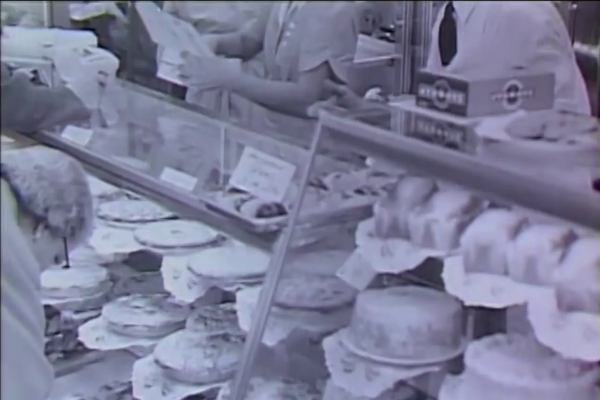

In [7]:
search_video("bakery with bread on the shelves", video_features, topk=1)

tensor([[[0.1754, 0.1742, 0.1750, 0.1742, 0.1770, 0.1748, 0.1744, 0.1724,
          0.1721, 0.1719, 0.1723, 0.1747, 0.1753, 0.1762, 0.1749, 0.1751,
          0.1737, 0.1747, 0.1728, 0.1721, 0.1716, 0.1725, 0.1715, 0.1722,
          0.1726, 0.1714, 0.1714, 0.1718, 0.1718, 0.1720, 0.1710, 0.1705,
          0.1710, 0.1708, 0.1710, 0.1718, 0.1712, 0.1726, 0.1757, 0.1764,
          0.1754, 0.1757, 0.1739, 0.1726, 0.1730, 0.1733, 0.1721, 0.1725,
          0.1736, 0.1735, 0.1746, 0.1755, 0.1751, 0.1755, 0.1759, 0.1766,
          0.1764, 0.1783, 0.1768, 0.1768, 0.1773, 0.1766, 0.1778, 0.1763,
          0.1748, 0.1738, 0.1734, 0.1745, 0.1750, 0.1749, 0.1743, 0.1731,
          0.1744, 0.1744, 0.1750, 0.1760, 0.1759, 0.1786, 0.1764, 0.1758,
          0.1758, 0.1741, 0.1745, 0.1736, 0.1739, 0.1753, 0.1747, 0.1744,
          0.1738, 0.1716, 0.1707, 0.1718, 0.1711, 0.1707, 0.1703, 0.1692,
          0.1697, 0.1692, 0.1706, 0.1710, 0.1707]]])
best_score: tensor([[[0.1786]]])
best_photo_idx: tensor([[[

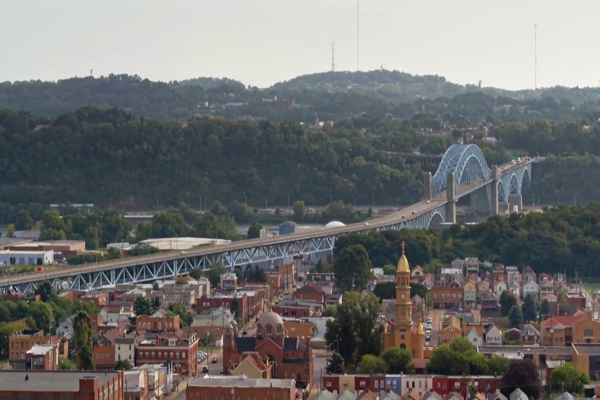

In [46]:
search_video("red car on a street", video_features, topk=1)

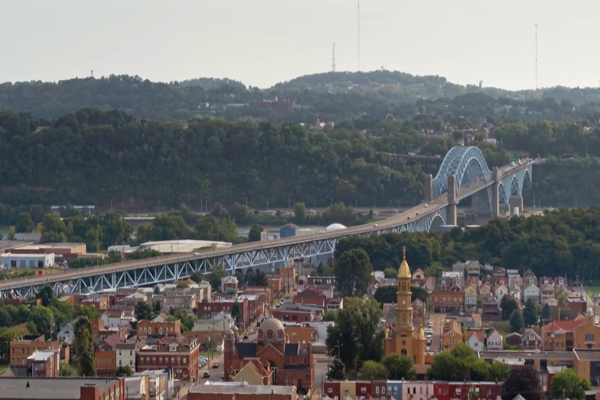

In [10]:
search_video("bridge over river", video_features, topk=1)